### This notebook is to look at delirium data closely, do some EDA.

## Imports

In [1]:
import os
import sys
sys.path.append("..")

import re
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import sqlalchemy
from sqlalchemy import func, select, desc
from sqlalchemy.sql.expression import and_, or_

from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection

import config
import cyclops
from cyclops.orm import Database
from cyclops.processors.diagnosis_codes import DiagnosisProcessor
from cyclops.processors.column_names import (
    ENCOUNTER_ID,
    DIAGNOSIS_CODE,
    ADMIT_TIMESTAMP,
    LAB_TEST_RESULT_VALUE,
    LAB_TEST_TIMESTAMP,
    LAB_TEST_NAME,
    LAB_TEST_RESULT_UNIT,
    REFERENCE_RANGE
)
from cyclops.processors.labs import LabsProcessor
from cyclops.processors.feature_handler import FeatureHandler

%load_ext autoreload

2022-03-02 12:42:39,677 INFO config          - Log file is /mnt/nfs/home/krishnanam/log.log
2022-03-02 12:42:39,753 INFO cyclops.utils.profile - Log file is /mnt/nfs/home/krishnanam/log.log
2022-03-02 12:42:39,758 INFO cyclops.orm     - Log file is /mnt/nfs/home/krishnanam/log.log
2022-03-02 12:42:39,774 INFO cyclops.processors.diagnosis_codes - Log file is /mnt/nfs/home/krishnanam/log.log
2022-03-02 12:42:39,787 INFO cyclops.processors.labs - Log file is /mnt/nfs/home/krishnanam/log.log


## Load config, setup ORM

In [2]:
cfg = config.read_config("../configs/default/*.yaml")
db = Database(cfg)

2022-03-02 12:42:41,456 INFO cyclops.orm     - Database setup, ready to run queries!


## String constants

In [3]:
GENC_ID = "genc_id"
PATIENT_ID = "patient_id"
HOSPITAL_ID = "hospital_id"
AGE = "age"
GENDER = "gender"
ADMIT_DATE_TIME = "admit_date_time"
DIAGNOSIS_TYPE = "diagnosis_type"
UNIQUE_LAB_NAMES = "unique_lab_names"
UNIQUE_LAB_COUNTS = "unique_lab_counts"
RESULT_VALUE = "result_value"
SAMPLE_COLLECTION_DATE_TIME = 'sample_collection_date_time'
UNIQUE_VITALS_NAMES = "unique_vitals_names"
UNIQUE_VITALS_COUNTS = "unique_vitals_counts"
VITALS_NAME = "vitals_name"
DISCHARGE_DISPOSITION = "discharge_disposition"
DELIRIUM_LABEL = "del_present"
ADMIT_DATE_TIME = "admit_date_time"
DISCHARGE_DATE_TIME = "discharge_date_time"
MEDICATION_NAME = "medication_name"
UNIQUE_MEDS_NAMES = "unique_meds_names"
UNIQUE_MEDS_COUNTS = "unique_meds_counts"

REPORT_SAVE_PATH = "/mnt/nfs/project/delirium/_reports"

## Plot utility functions

In [4]:
def setup_plot(plot_handle: matplotlib.axes.SubplotBase,
               title: str,
               xlabel: str,
               ylabel: str,
               legend: list):
    """Setup plot.
    
    Parameters
    ----------
    plot_handle: matplotlib.axes.SubplotBase
        Subplot handle.
    title: str
        Title of plot.
    xlabel: str
        Label for x-axis.
    ylabel: str
        Label for y-axis.
    legend: list
        Legend for different sub-groups.
    """
    plot_handle.title.set_text(title)
    plot_handle.set_xlabel(xlabel, fontsize=20)
    plot_handle.set_ylabel(ylabel, fontsize=20)  
    plot_handle.legend(legend, loc=1)
    
    
def set_bars_color(bars: matplotlib.container.BarContainer,
                   color: str):
    """Set color attribute for bars in bar plots.
    
    Parameters
    ----------
    bars: matplotlib.container.BarContainer
        Bars.
    color: str
        Color.
    """
    for bar in bars:
        bar.set_color(color)

## Delirium data distribution

2022-03-02 12:42:41,680 INFO cyclops.orm     - Query returned successfully!
2022-03-02 12:42:41,682 INFO cyclops.utils.profile - Finished executing function run_query in 0.17212677001953125 s


Mean Age: Delirium present: 76.57520325203252, No delirium: 66.1254819488258


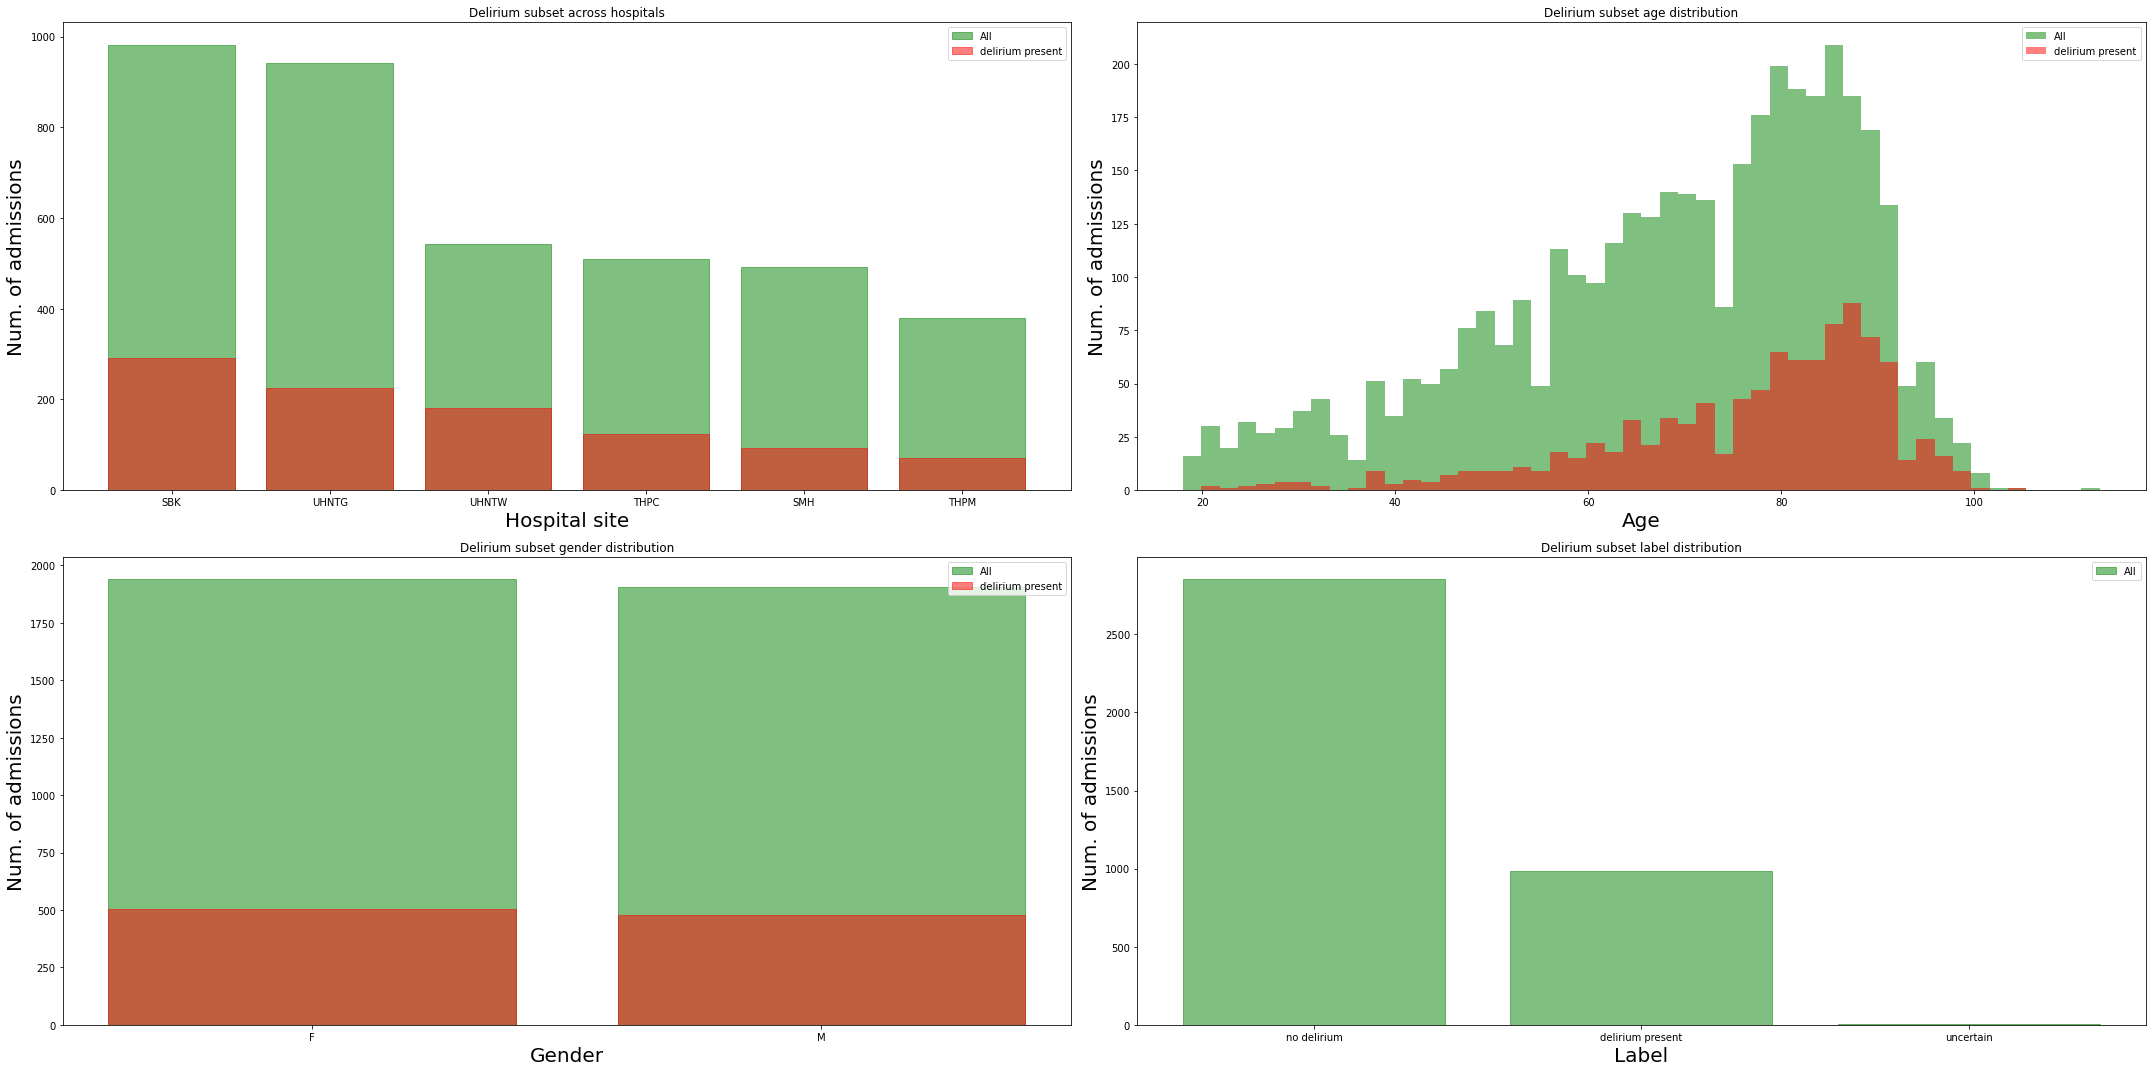

In [5]:
delirium_admin_query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
                              db.public.ip_administrative.genc_id,
                              db.public.ip_administrative.hospital_id,
                              db.public.ip_administrative.admit_date_time,
                              db.public.ip_administrative.age,
                              db.public.ip_administrative.gender,
                              db.public.ip_administrative.discharge_date_time,
                              db.public.ip_administrative.discharge_disposition,
                              db.public.ip_administrative.del_present,
                              db.public.ip_administrative.gemini_cohort
                             ).where(db.public.ip_administrative.gemini_cohort == True).subquery()
admin_data = db.run_query(delirium_admin_query)
admin_data_pos = admin_data.loc[admin_data[DELIRIUM_LABEL] == 1]
admin_data_neg = admin_data.loc[admin_data[DELIRIUM_LABEL] == 2]


fig, axs = plt.subplots(2, 2, figsize=(30, 15), tight_layout=True)

# Across hospitals.
hosp_counts = list(admin_data[HOSPITAL_ID].value_counts())
hospitals = list(admin_data[HOSPITAL_ID].unique())
hosp_counts_pos = list(admin_data_pos[HOSPITAL_ID].value_counts())

hosp_bars = axs[0][0].bar(hospitals, hosp_counts, alpha = 0.5)
set_bars_color(hosp_bars, 'g')
hosp_bars_pos = axs[0][0].bar(hospitals, hosp_counts_pos, alpha = 0.5)
set_bars_color(hosp_bars_pos, 'r')
setup_plot(axs[0][0], 
           "Delirium subset across hospitals",
           "Hospital site", 
           "Num. of admissions",
           ['All', 'delirium present'])

# Across age.
ages = admin_data[AGE]
ages_pos = admin_data_pos[AGE]
ages_neg = admin_data_neg[AGE]
print(f"Mean Age: Delirium present: {np.array(ages_pos).mean()}, No delirium: {np.array(ages_neg).mean()}")

(_, bins, _) = axs[0][1].hist(ages, bins=50, alpha=0.5, color='g')
axs[0][1].hist(ages_pos, bins=bins, alpha=0.5, color='r')
setup_plot(axs[0][1], 
           "Delirium subset age distribution",
           "Age", 
           "Num. of admissions",
           ['All', 'delirium present'])

# Across gender.
genders = list(admin_data[GENDER].unique())
gender_counts = list(admin_data[GENDER].value_counts())
gender_counts_pos = list(admin_data_pos[GENDER].value_counts())

gender_bars = axs[1][0].bar(genders, gender_counts, alpha = 0.5)
set_bars_color(gender_bars, 'g')
gender_bars_pos = axs[1][0].bar(genders, gender_counts_pos, alpha = 0.5)
set_bars_color(gender_bars_pos, 'r')
setup_plot(axs[1][0], 
           "Delirium subset gender distribution",
           "Gender", 
           "Num. of admissions",
           ['All', 'delirium present'])

# Across labels.
DEL_LABEL_MAP = {
    1: "delirium present",
    2: "no delirium",
    3: "uncertain"
}
label_counts = admin_data[DELIRIUM_LABEL].value_counts().to_dict().values()
labels = admin_data[DELIRIUM_LABEL].value_counts().to_dict().keys()
labels = [DEL_LABEL_MAP[l] for l in labels]

label_bars = axs[1][1].bar(labels, label_counts, alpha = 0.5)
set_bars_color(label_bars, 'g')
setup_plot(axs[1][1], 
           "Delirium subset label distribution",
           "Label", 
           "Num. of admissions",
           ['All'])

plt.show()

## Diagnosis lookup table

In [6]:
# Diagnosis lookup table on GEMINI
lookup_query = select(db.public.lookup_diagnosis.variable,
                      db.public.lookup_diagnosis.value,
                      db.public.lookup_diagnosis.description).subquery()
diagnosis_lookup_data = db.run_query(lookup_query)
print(diagnosis_lookup_data)
diagnosis_lookup_data_dict = diagnosis_lookup_data[["value", "description"]].to_dict()
diagnosis_type_map = {}
for key, diagnosis_type in diagnosis_lookup_data_dict["value"].items():
    diagnosis_type_map[diagnosis_type] = diagnosis_lookup_data_dict["description"][key]

2022-03-02 12:42:43,134 INFO cyclops.orm     - Query returned successfully!
2022-03-02 12:42:43,136 INFO cyclops.utils.profile - Finished executing function run_query in 0.010336637496948242 s


          variable value                        description
0   diagnosis_type     M         Most Responsible Diagnosis
1   diagnosis_type     1              Pre-Admit Comorbidity
2   diagnosis_type     2             Post-Admit Comorbidity
3   diagnosis_type     3                Secondary Diagnosis
4   diagnosis_type     4                   Morphology Codes
5   diagnosis_type     5                Admitting Diagnosis
6   diagnosis_type     6   Proxy Most Responsible Diagnosis
7   diagnosis_type     9      External Cause of Injury Code
8   diagnosis_type     0                            Newborn
9   diagnosis_type     W   First Service Transfer Diagnosis
10  diagnosis_type     X  Second Service Transfer Diagnosis
11  diagnosis_type     Y   Third Service Transfer Diagnosis


## Diagnosis type distribution (delirium)

2022-03-02 12:42:43,537 INFO cyclops.orm     - Query returned successfully!
2022-03-02 12:42:43,540 INFO cyclops.utils.profile - Finished executing function run_query in 0.3813130855560303 s


Number of diagnosis codes: 31623


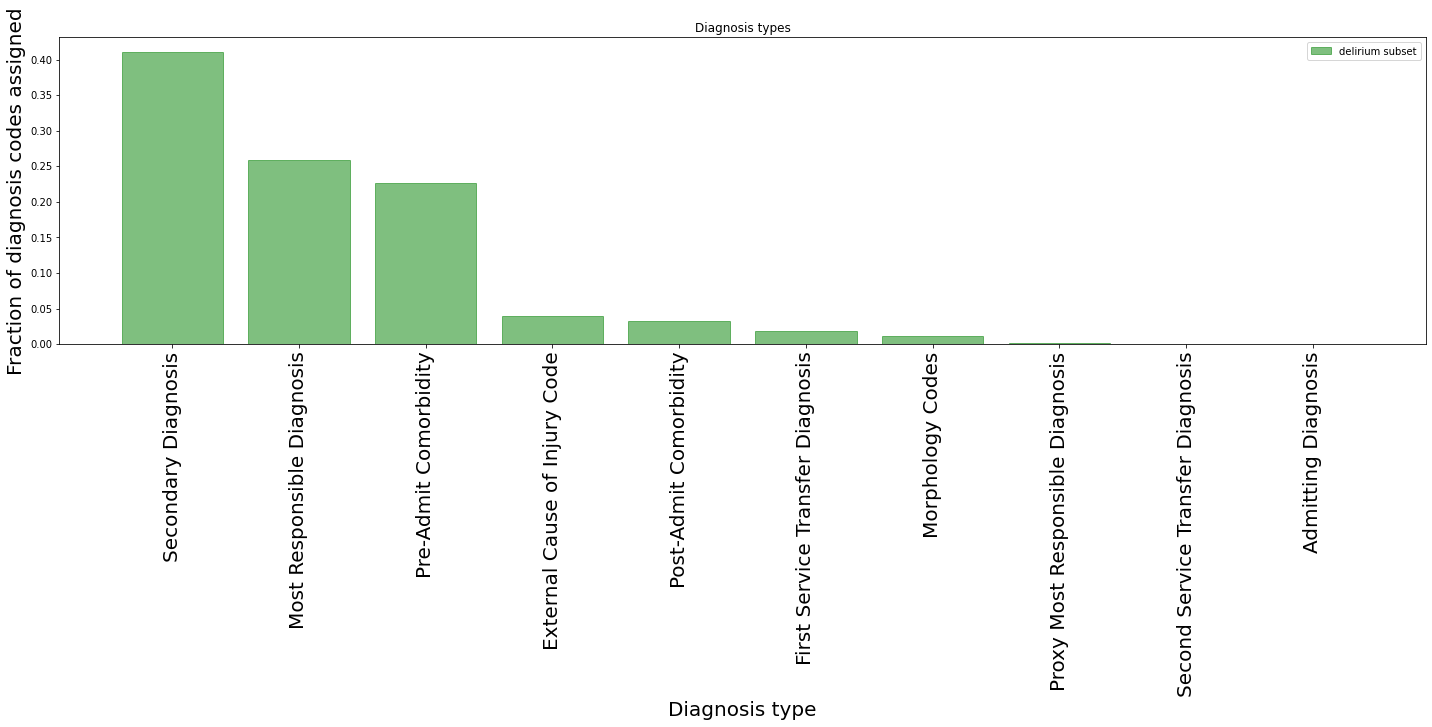

In [7]:
diagnosis_query = select(db.public.diagnosis.genc_id,
                         db.public.diagnosis.diagnosis_code,
                         db.public.diagnosis.diagnosis_type,
                         db.public.diagnosis.is_er_diagnosis).subquery()
query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
               db.public.ip_administrative.genc_id,
               db.public.ip_administrative.hospital_id,
               db.public.ip_administrative.admit_date_time,
               db.public.ip_administrative.discharge_date_time,
               db.public.ip_administrative.del_present,
               db.public.ip_administrative.gemini_cohort,
               diagnosis_query.c.diagnosis_code,
               diagnosis_query.c.diagnosis_type,
               diagnosis_query.c.is_er_diagnosis
              ).join(diagnosis_query,
                     db.public.ip_administrative.genc_id == diagnosis_query.c.genc_id
                    ).where(db.public.ip_administrative.gemini_cohort == True)
diagnosis_data = db.run_query(query)
diagnosis_types = diagnosis_data[DIAGNOSIS_TYPE].value_counts()
print(f"Number of diagnosis codes: {len(diagnosis_data)}")

fig, axs = plt.subplots(1, 1, figsize=(20, 10), tight_layout=True)
dignosis_types_bars = plt.bar(list(range(len(diagnosis_types))),
                          np.array(diagnosis_types.values) / sum(diagnosis_types.values),
                          alpha = 0.5)
set_bars_color(dignosis_types_bars, 'g')
axs.set_xticks(range(len(diagnosis_types)),
               [diagnosis_type_map[key] for key in diagnosis_types.keys()],
               rotation='vertical',
               fontsize=20)
setup_plot(axs, 
           "Diagnosis types",
           "Diagnosis type", 
           "Fraction of diagnosis codes assigned",
           ['delirium subset'])

plt.show()

## Convert diagnosis codes to ICD 10 codes and hence binary features.

In [8]:
%autoreload 2

pd.set_option('display.max_columns', None)

data = pd.read_hdf(
    "/mnt/nfs/project/delirium/_extract/delirium_extract.h5",
    key="query_gemini_delirium_diagnosis"
)
must_have_columns = [
    ENCOUNTER_ID,
    DIAGNOSIS_CODE
]
feature_handler = FeatureHandler()
diagnosis_processor = DiagnosisProcessor(data, must_have_columns)
diagnosis_features = diagnosis_processor.process()
feature_handler.add_features(diagnosis_features)

2022-03-02 12:42:44,072 INFO cyclops.processors.diagnosis_codes - Processing raw diagnosis codes...
2022-03-02 12:42:44,075 INFO cyclops.processors.diagnosis_codes - # diagnosis codes: 31623, # encounters: 3845
2022-03-02 12:42:45,825 INFO cyclops.processors.diagnosis_codes - Converting diagnosis codes to ICD codes...
2022-03-02 12:42:45,827 INFO cyclops.processors.diagnosis_codes - # diagnosis codes: 31623, # encounters: 3845
2022-03-02 12:42:45,836 INFO cyclops.processors.diagnosis_codes - Removing unmapped, i.e. nan codes...
2022-03-02 12:42:45,838 INFO cyclops.processors.diagnosis_codes - # diagnosis codes: 30627, # encounters: 3845
2022-03-02 12:42:48,301 INFO cyclops.utils.profile - Finished executing function process in 4.228961706161499 s


## Data quality report (diagnosis codes)

In [9]:
dashboard = Dashboard(tabs=[DataQualityTab()])
column_mapping = ColumnMapping(categorical_features=diagnosis_features.columns)
dashboard.calculate(reference_data=feature_handler.df, current_data=None, column_mapping=column_mapping)
dashboard.save(os.path.join(REPORT_SAVE_PATH, "delirium_diagnosis_processed.html"))

## Discharge disposition

2022-03-02 12:42:49,562 INFO cyclops.orm     - Query returned successfully!
2022-03-02 12:42:49,565 INFO cyclops.utils.profile - Finished executing function run_query in 0.020048856735229492 s


                 variable value                  description
7   discharge_disposition     1       Acute Care Institution
8   discharge_disposition     2                        Other
9   discharge_disposition     3                        Other
10  discharge_disposition     4                         Home
11  discharge_disposition     5                         Home
12  discharge_disposition     6                         Home
13  discharge_disposition     7                         Died
14  discharge_disposition     8                        Other
15  discharge_disposition     9                        Other
16  discharge_disposition    12                         Home
17  discharge_disposition    10       Acute Care Institution
18  discharge_disposition    20         Transferred to other
19  discharge_disposition    30         Transferred to other
20  discharge_disposition    40         Transferred to other
21  discharge_disposition    90         Transferred to other
22  discharge_dispositio

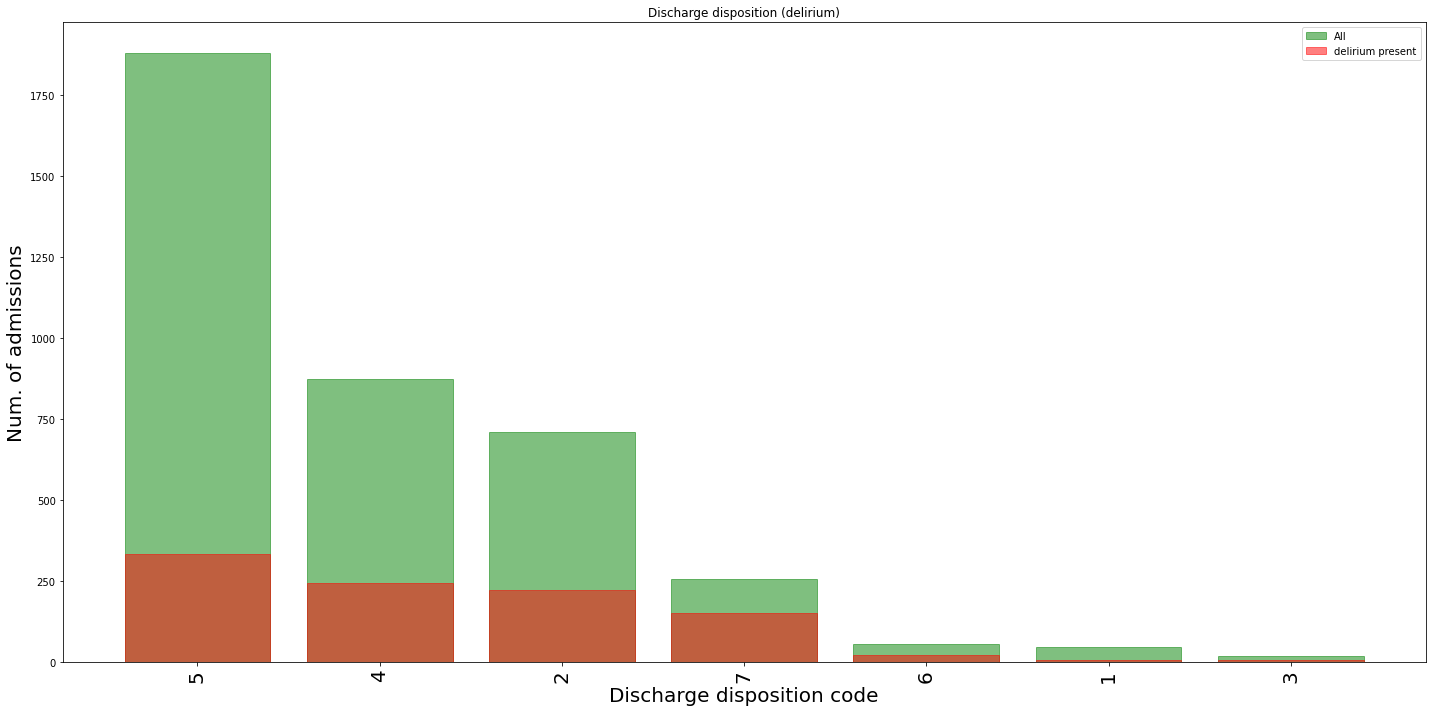

In [10]:
# Discharge disposition codes on GEMINI
lookup_query = select(db.public.lookup_ip_administrative.variable,
                      db.public.lookup_ip_administrative.value,
                      db.public.lookup_ip_administrative.description).subquery()
admin_lookup_data = db.run_query(lookup_query)
discharge_codes = admin_lookup_data.loc[admin_lookup_data["variable"] == DISCHARGE_DISPOSITION]
print(discharge_codes)

# Longer descriptions taken from CIHI portal 
# https://www.cihi.ca/sites/default/files/document/cihi-portal-release-notes-release-13.1-en_en02jpdg.pdf
DISCHARGE_DISPOSITION_MAP = {
    1: "Transferred to acute inpatient institution (other acute, psych, etc.)",
    2: "Transferred continuing care (other facility or level of care in same)",
    3: "Transfer other (ambulatory/palliative, addiction/jail, child agency)",
    4: "Discharged to a home setting with support services (senior lodge, attendant care, home care . . .)",
    5: "Discharged home (no external support needed, not incl. nursing homes)",
    6: "Signed out (leaving against medical advice, AWOL)",
    7: "Died"
}
discharge_disposition_counts = admin_data[DISCHARGE_DISPOSITION].value_counts()
discharge_disposition_counts_pos = admin_data_pos[DISCHARGE_DISPOSITION].value_counts()
for disch_code, meaning in DISCHARGE_DISPOSITION_MAP.items():
    print(f"{meaning}: {discharge_disposition_counts[disch_code]}")

fig, axs = plt.subplots(1, 1, figsize=(20, 10), tight_layout=True)
disch_disp_bars = plt.bar(list(range(len(discharge_disposition_counts))),
                          discharge_disposition_counts.values,
                          alpha = 0.5)
set_bars_color(disch_disp_bars, 'g')
disch_disp_bars_pos = plt.bar(list(range(len(discharge_disposition_counts_pos))),
                              discharge_disposition_counts_pos.values,
                              alpha = 0.5)
set_bars_color(disch_disp_bars_pos, 'r')
axs.set_xticks(range(len(discharge_disposition_counts)),
               discharge_disposition_counts.keys(),
               rotation='vertical',
               fontsize=20)
setup_plot(axs, 
           "Discharge disposition (delirium)",
           "Discharge disposition code", 
           "Num. of admissions",
           ['All', 'delirium present'])

plt.show()

# Fraction of encounters with delirium positive label, and disch. dispostion (7) - is significantly higher compared to others.

## Year of care, LOS distribution (delirium subset)

Mean LOS (days): Delirium present: 14.075203252032521, No delirium: 6.058885383806519


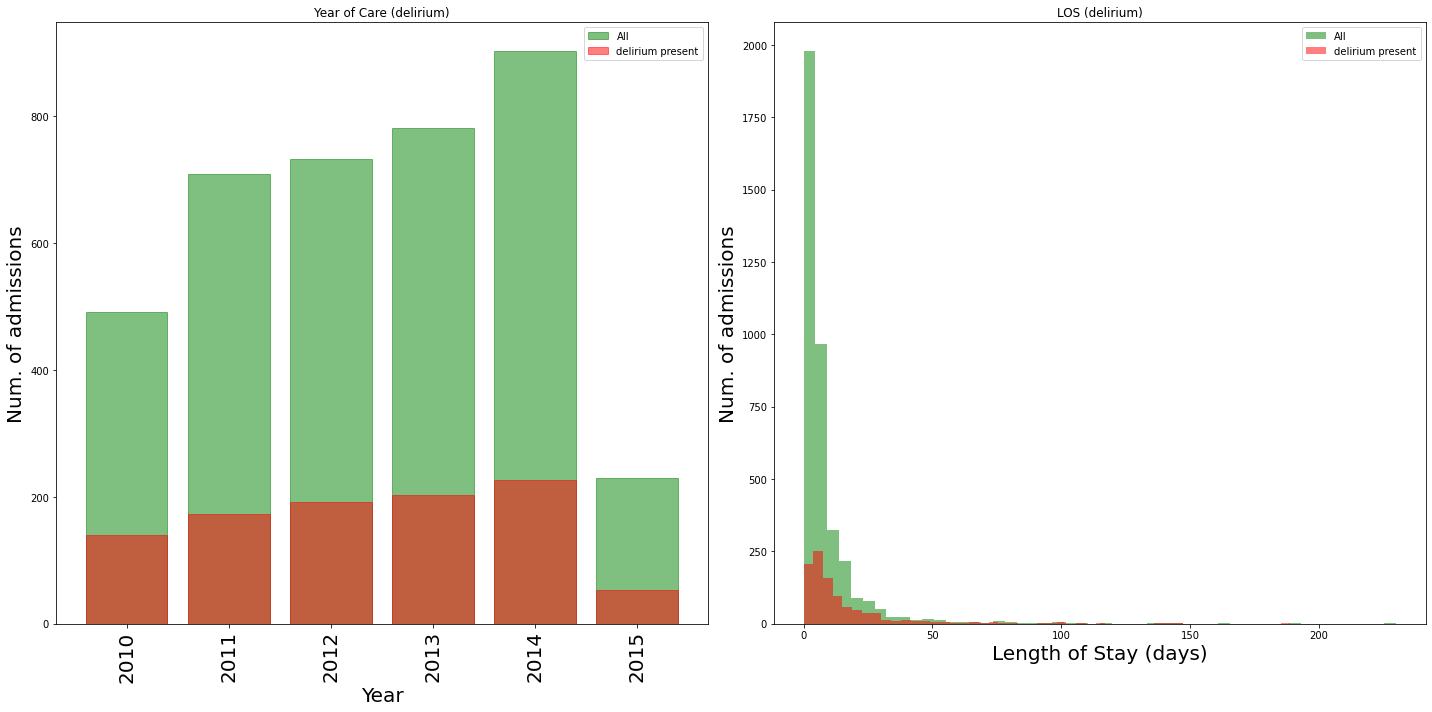

In [11]:
admit_discharge_times = admin_data[[ADMIT_DATE_TIME, DISCHARGE_DATE_TIME]]
years_counts = admit_discharge_times[ADMIT_DATE_TIME].dt.year.value_counts().to_dict()
years_counts = OrderedDict(sorted(years_counts.items()))

admit_discharge_times_pos = admin_data_pos[[ADMIT_DATE_TIME, DISCHARGE_DATE_TIME]]
years_counts_pos = admit_discharge_times_pos[ADMIT_DATE_TIME].dt.year.value_counts().to_dict()
years_counts_pos = OrderedDict(sorted(years_counts_pos.items()))

fig, axs = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
years_bars = axs[0].bar(list(range(len(years_counts))), years_counts.values(), alpha = 0.5)
set_bars_color(years_bars, 'g')
years_bars_pos = axs[0].bar(list(range(len(years_counts_pos))), years_counts_pos.values(), alpha = 0.5)
set_bars_color(years_bars_pos, 'r')
axs[0].set_xticks(range(len(years_counts)), years_counts.keys(), rotation='vertical', fontsize=20)
setup_plot(axs[0], 
           "Year of Care (delirium)",
           "Year", 
           "Num. of admissions",
           ['All', 'delirium present'])

los = admit_discharge_times[DISCHARGE_DATE_TIME] - admit_discharge_times[ADMIT_DATE_TIME]
los = los.astype('timedelta64[D]')
los_pos = admit_discharge_times_pos[DISCHARGE_DATE_TIME] - admit_discharge_times_pos[ADMIT_DATE_TIME]
los_pos = los_pos.astype('timedelta64[D]')
admit_discharge_times_neg = admin_data_neg[[ADMIT_DATE_TIME, DISCHARGE_DATE_TIME]]
los_neg = admit_discharge_times_neg[DISCHARGE_DATE_TIME] - admit_discharge_times_neg[ADMIT_DATE_TIME]
los_neg = los_neg.astype('timedelta64[D]')
print(f"Mean LOS (days): Delirium present: {np.array(los_pos).mean()}, No delirium: {np.array(los_neg).mean()}")
axs[1].hist(los, bins=50, alpha=0.5, color='g')
axs[1].hist(los_pos, bins=50, alpha=0.5, color='r')
setup_plot(axs[1], 
           "LOS (delirium)",
           "Length of Stay (days)", 
           "Num. of admissions",
           ['All', 'delirium present'])

plt.show()

## Find out top unique lab tests across GEMINI

In [12]:
"""Unique lab names and counts. Get top k lab tests ordered.

`lab_test_name_mapped` has common tests mapped across sites by GEMINI.
`lab_test_name_raw` has raw test names which are much greater in number (most different, unmapped across sites).
"""
k = 100

unique_lab_names = func.lower(db.public.lab.lab_test_name_mapped)
query = select(unique_lab_names.label(UNIQUE_LAB_NAMES),
               func.count(unique_lab_names).label(UNIQUE_LAB_COUNTS)
              )
query = query.group_by(UNIQUE_LAB_NAMES).order_by(desc(UNIQUE_LAB_COUNTS))

lab_counts = db.run_query(query)
print(f"Num. of unique lab tests: {len(lab_counts)}")
print(lab_counts.head(k))

2022-03-02 12:43:26,962 INFO cyclops.orm     - Query returned successfully!
2022-03-02 12:43:26,967 INFO cyclops.utils.profile - Finished executing function run_query in 36.3306725025177 s


Num. of unique lab tests: 55
                          unique_lab_names  unique_lab_counts
0                                   sodium            3043713
1                                potassium            2620534
2                               lymphocyte            2555905
3                               hemoglobin            2405465
4                               creatinine            2371876
5                              bicarbonate            2325705
6                   white blood cell count            2310123
7                           platelet count            2307750
8                   mean cell volume (mcv)            2299557
9                               hematocrit            2258974
10                             neutrophils            2193498
11                   glucose point of care            1840409
12                              urinalysis            1405597
13                          glucose random            1279665
14               blood urea nitrogen (bun

## Get the mapped lab tests for encounters with delirium label

In [13]:
lab_test_name = func.lower(db.public.lab.lab_test_name_mapped)
lab_query = select(db.public.lab.genc_id,
                   lab_test_name.label(LAB_TEST_NAME),
                   db.public.lab.result_value,
                   db.public.lab.result_unit,
                   db.public.lab.sample_collection_date_time).subquery()
query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
               db.public.ip_administrative.genc_id,
               db.public.ip_administrative.hospital_id,
               db.public.ip_administrative.admit_date_time,
               db.public.ip_administrative.discharge_date_time,
               db.public.ip_administrative.del_present,
               db.public.ip_administrative.gemini_cohort,
               lab_query.c.lab_test_name,
               lab_query.c.result_value,
               lab_query.c.result_unit,
               lab_query.c.sample_collection_date_time,
              ).join(lab_query,
                     db.public.ip_administrative.genc_id == lab_query.c.genc_id
                    ).where(and_(lab_query.c.lab_test_name != '',
                                 db.public.ip_administrative.gemini_cohort == True))
labs = db.run_query(query)
print(len(labs))
print(labs[GENC_ID].nunique())

2022-03-02 12:44:07,543 INFO cyclops.orm     - Query returned successfully!
2022-03-02 12:44:07,549 INFO cyclops.utils.profile - Finished executing function run_query in 40.477630615234375 s


480093
3837


## Plot distribution of lab tests ordered (delirium subset vs. all admissions)

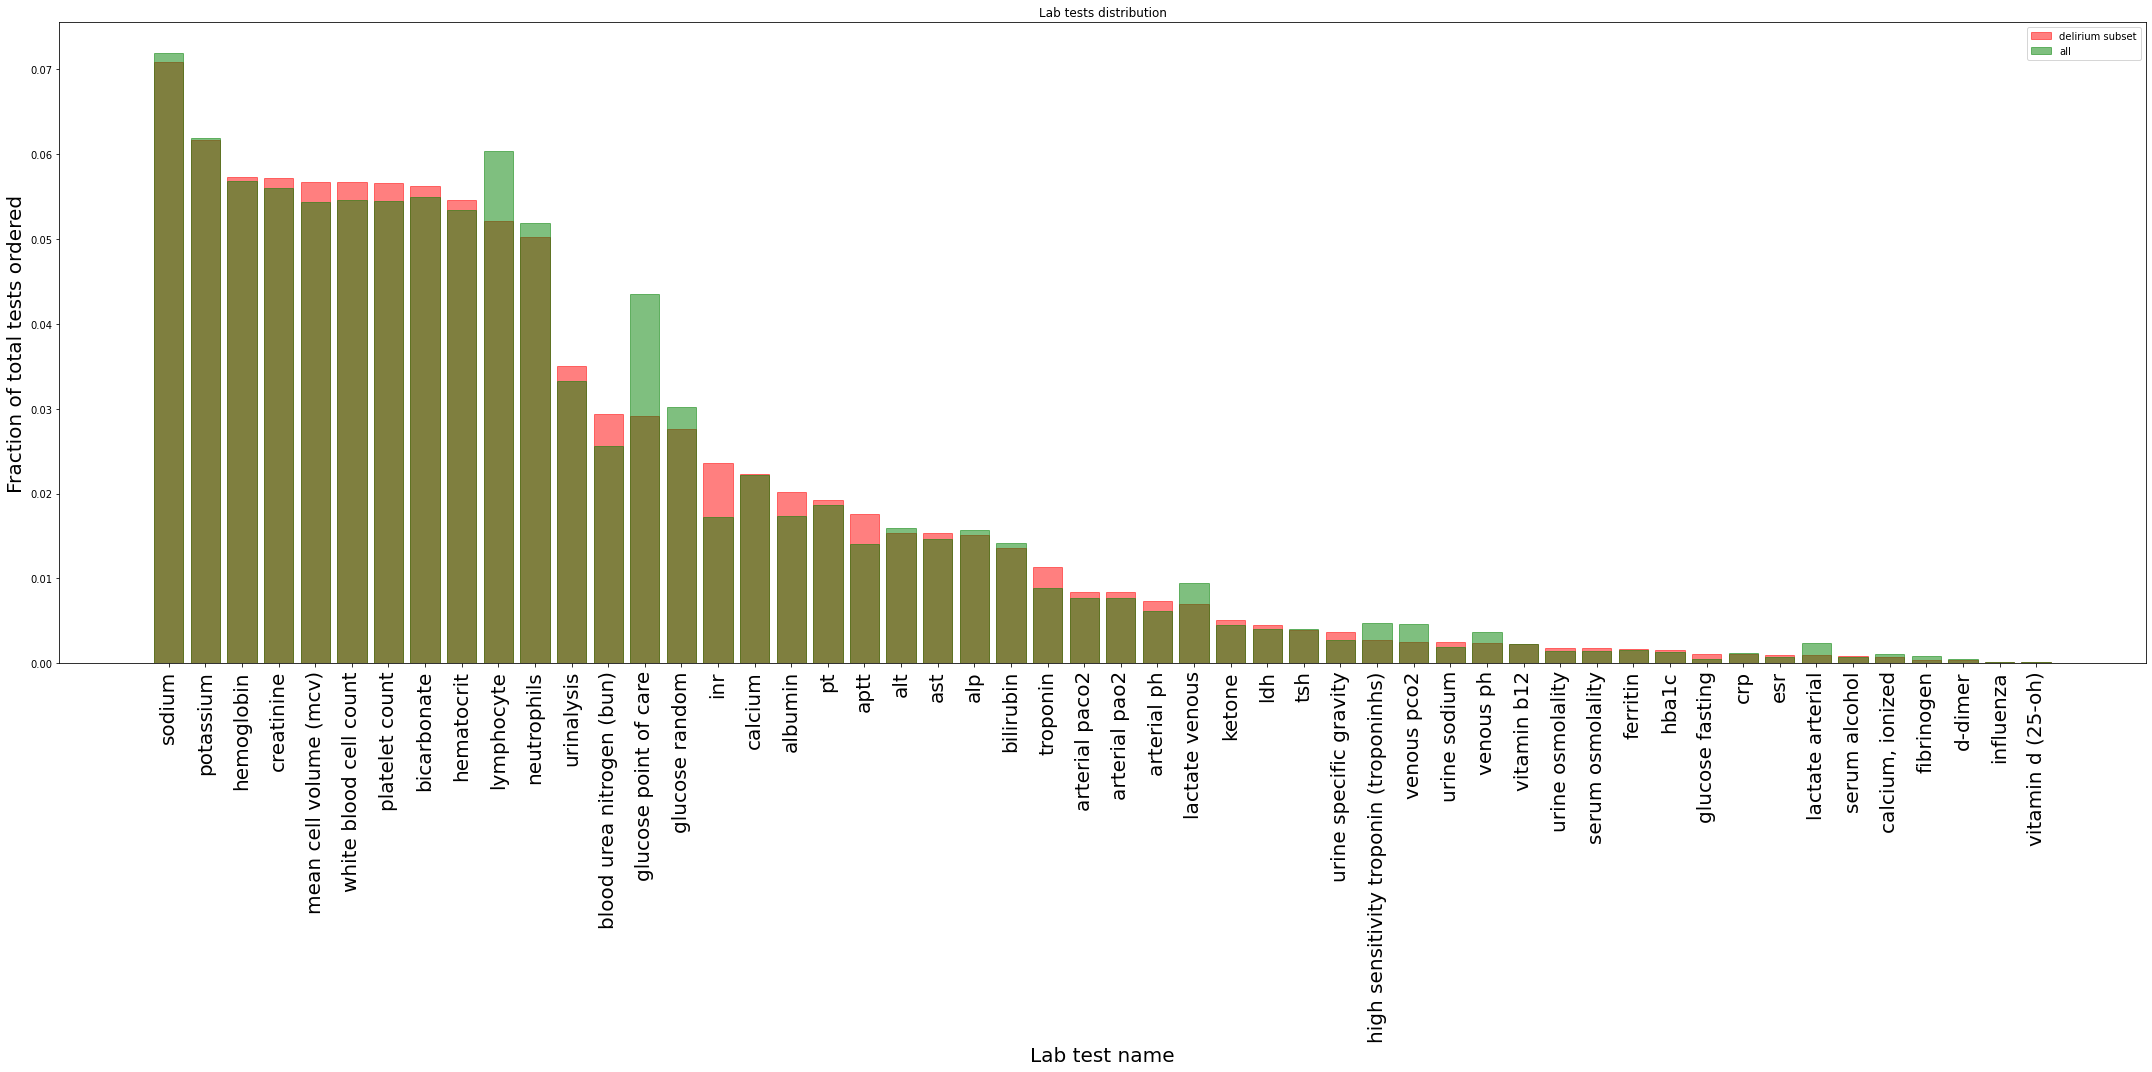

In [14]:
del_lab_names = labs[LAB_TEST_NAME].value_counts().keys()
del_lab_counts = labs[LAB_TEST_NAME].value_counts().values
del_lab_counts = np.array(del_lab_counts) / sum(del_lab_counts)

all_lab_counts = [int(lab_counts.loc[lab_counts[UNIQUE_LAB_NAMES] == ln][UNIQUE_LAB_COUNTS]) for ln in del_lab_names]
all_lab_counts = np.array(all_lab_counts) / sum(all_lab_counts)

fig, axs = plt.subplots(1, 1, figsize=(30, 15), tight_layout=True)
delirum_labs_bars = plt.bar(list(range(len(del_lab_names))), del_lab_counts, alpha = 0.5)
set_bars_color(delirum_labs_bars, 'r')
all_labs_bars = plt.bar(list(range(len(del_lab_names))), all_lab_counts, alpha = 0.5)
set_bars_color(all_labs_bars, 'g')
axs.set_xticks(range(len(delirum_labs_bars)), del_lab_names, rotation='vertical', fontsize=20)
setup_plot(axs, 
           "Lab tests distribution",
           "Lab test name", 
           "Fraction of total tests ordered",
           ['delirium subset', 'all'])

plt.show()

## Lab tests distribution across sites (delirium).

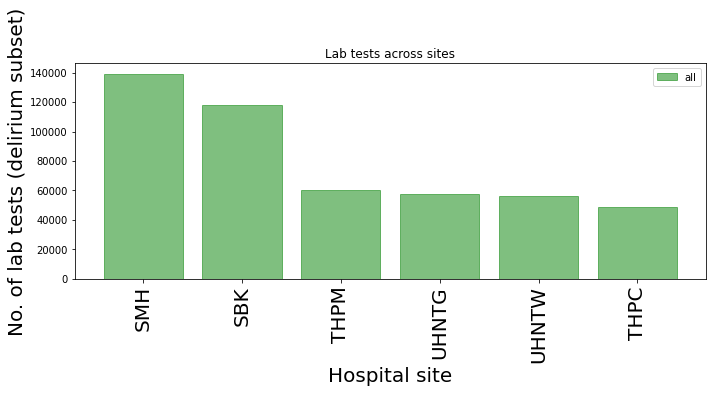

In [15]:
lab_counts_hosp = labs[HOSPITAL_ID].value_counts()

fig, axs = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
labs_hosp_bars = plt.bar(list(range(len(lab_counts_hosp))), lab_counts_hosp.values, alpha = 0.5)
set_bars_color(labs_hosp_bars, 'g')
axs.set_xticks(range(len(labs_hosp_bars)), lab_counts_hosp.keys(), rotation='vertical', fontsize=20)
setup_plot(axs, 
           "Lab tests across sites",
           "Hospital site", 
           "No. of lab tests (delirium subset)",
           ['all'])

plt.show()

## Extract lab result values, units, aggregation

In [16]:
# Feature Engineering Questions:

# 1. When lab result is 'TRACE' should we encode that as 0 or 1 or maybe a new label for "uncertain"? 
# Maybe empirically test?
# 2. What does 'FINAL' mean in an influenza test? Right now, its discarded.

%autoreload 2

data = pd.read_hdf(
    "/mnt/nfs/project/delirium/_extract/delirium_extract.h5",
    key="query_gemini_delirium_lab"
)
must_have_columns = [
    ENCOUNTER_ID,
    ADMIT_TIMESTAMP,
    LAB_TEST_NAME,
    LAB_TEST_TIMESTAMP,
    LAB_TEST_RESULT_VALUE,
    LAB_TEST_RESULT_UNIT,
    REFERENCE_RANGE
]
feature_handler = FeatureHandler()
labs_processor = LabsProcessor(data, must_have_columns)
lab_features = labs_processor.process()
feature_handler.add_features(lab_features)

print("Reference range unique values")
print(labs_processor.data[REFERENCE_RANGE].unique())

2022-03-02 12:44:11,191 INFO cyclops.processors.labs - Processing raw lab data...
2022-03-02 12:44:11,197 INFO cyclops.processors.labs - # labs: 480093, # encounters: 3837
2022-03-02 12:44:11,329 INFO cyclops.processors.labs - Filtering labs within aggregation window...
2022-03-02 12:44:11,334 INFO cyclops.processors.labs - # labs: 170873, # encounters: 3830
2022-03-02 12:44:11,623 INFO cyclops.processors.labs - Fixing inequalities and removing outlier values...
2022-03-02 12:44:11,627 INFO cyclops.processors.labs - # labs: 170873, # encounters: 3830
2022-03-02 12:44:11,706 INFO cyclops.processors.labs - Removing labs with empty result values...
2022-03-02 12:44:11,711 INFO cyclops.processors.labs - # labs: 157650, # encounters: 3830
2022-03-02 12:44:11,713 INFO cyclops.processors.labs - Converting string result values to numeric...
2022-03-02 12:44:11,752 INFO cyclops.processors.labs - Cleaning units and converting to SI...
2022-03-02 12:44:12,154 INFO cyclops.processors.labs - Creati

Reference range unique values
['' '1-20' '1-15' '1-12' '0 - 15' '0 - 20' '0 - 30' '0 - 10' 'TETRR'
 'Not Found' '0 - 17' '3.9-6.1' '20-465' '10-290' '22-322' '24-336'
 '14-186' '30 - 280' '12 - 192' '20 - 400' '2.10-4.10' '>2.00' '1.8 - 4'
 '1.80 - 4.00' '3.9-7.9' '4.0-6.0' 'Negative' '4.0 - 8.0' 'NEG <2.8'
 '4.0 - 6.0' '4 - 6' '4.0 - 7.8' '4 - 7.8' 'NEG <5' '<0.057' '<0.060'
 '0.390 - 0.490' '.38 - .48' '0.345 - 0.450' '.37 - .48' '0.350-0.470'
 '0.400-0.530' '0.350-0.450' '0.380-0.500' '0.330-0.480' '0.350-0.510'
 '0.340 - 0.490' '0.390 - 0.540' '118-155' '140-175' '115-150' '135-170'
 '130-180' '120-160' '115 - 165' '130 - 180' '0.036-0.065' '130 - 170'
 '115 - 155' '0.0 - 5.0' '0 - 5' '0.8-1.2' '0.90 - 1.20' '.9 - 1.2'
 '0.90 - 1.10' '1.15-1.30' '1.15-1.29' 'NEG <0.5' '0.5 - 1.8' '.5 - 1.8'
 '<1.7' '297-537' '100-200' '100-230' '0.5 - 2.0' '0.5 - 2.3' '.5 - 2.3'
 '0.7-2.1' '0.5-1.6' '100 - 195' '100 - 250' '4.0-11.0' 'NEG <10'
 '1.0-4.0' '1.0 - 4.0' '0.8-3.5' '82.0 - 97.0' '82 - 97

## Data quality report (labs)

In [17]:
dashboard = Dashboard(tabs=[DataQualityTab()])
column_mapping = ColumnMapping(numerical_features=lab_features.columns)
dashboard.calculate(reference_data=feature_handler.df, current_data=None, column_mapping=column_mapping)
dashboard.save(os.path.join(REPORT_SAVE_PATH, "delirium_labs_processed.html"))

## Find out mapped common vitals across GEMINI

In [18]:
"""Unique vital measurement names and counts. Get top k vitals measured.

`measurement_mapped` has common vital measurements mapped across sites by GEMINI.
`measurement_name` has raw vitals names which are much greater in number (most different, unmapped across sites).
"""

k = 11

unique_vitals_names = func.lower(db.public.vitals.measurement_mapped)
query = select(unique_vitals_names.label(UNIQUE_VITALS_NAMES),
               func.count(unique_vitals_names).label(UNIQUE_VITALS_COUNTS)
              )
query = query.group_by(UNIQUE_VITALS_NAMES).order_by(desc(UNIQUE_VITALS_COUNTS))

vitals_counts = db.run_query(query)
print(f"Num. of unique vitals measurements: {len(vitals_counts)}")
print(vitals_counts.head(k))

2022-03-02 12:44:41,538 INFO cyclops.orm     - Query returned successfully!
2022-03-02 12:44:41,541 INFO cyclops.utils.profile - Finished executing function run_query in 1.6771323680877686 s


Num. of unique vitals measurements: 12
   unique_vitals_names  unique_vitals_counts
0          temperature               1056374
1           heart rate                839616
2          systolic bp                837673
3         diastolic bp                837591
4    oxygen saturation                681903
5     respiratory rate                671321
6      oxygen_delivery                609249
7                  cam                472200
8                 fio2                445510
9     oxygen flow rate                335422
10              weight                120526


## Explore vitals data for delirium subset

In [19]:
common_vitals = list(vitals_counts.head(k)[UNIQUE_VITALS_NAMES])
vitals_name = func.lower(db.public.vitals.measurement_mapped)
vitals_query = select(db.public.vitals.genc_id,
                      vitals_name.label(VITALS_NAME)).subquery()
query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
               db.public.ip_administrative.genc_id,
               db.public.ip_administrative.hospital_id,
               db.public.ip_administrative.del_present,
               db.public.ip_administrative.gemini_cohort,
               vitals_query.c.vitals_name,
              ).join(vitals_query,
                     db.public.ip_administrative.genc_id == vitals_query.c.genc_id
                    ).where(and_(vitals_query.c.vitals_name.in_(common_vitals),
                                 db.public.ip_administrative.gemini_cohort == True))
vitals = db.run_query(query)
print(vitals[GENC_ID].nunique())

# No vitals data for delirium subset??? Maybe ask why?

2022-03-02 12:44:43,204 INFO cyclops.orm     - Query returned successfully!
2022-03-02 12:44:43,206 INFO cyclops.utils.profile - Finished executing function run_query in 1.6204769611358643 s


0


## Find out top unique medications across GEMINI

In [20]:
"""Unique medications names (raw) and counts. Get top k medications.

`med_id_generic_name_raw` has raw test names which are much greater in number (most different, unmapped across sites).
"""
k = 100

unique_meds_names = func.lower(db.public.pharmacy.med_id_generic_name_raw)
query = select(unique_meds_names.label(UNIQUE_MEDS_NAMES),
               func.count(unique_meds_names).label(UNIQUE_MEDS_COUNTS)
              )
query = query.group_by(UNIQUE_MEDS_NAMES).order_by(desc(UNIQUE_MEDS_COUNTS))

meds_counts = db.run_query(query)
print(f"Num. of unique medications: {len(meds_counts)}")
meds_counts = meds_counts.head(k)
meds_names_fixed = list(meds_counts[UNIQUE_MEDS_NAMES])[1:] # From index 1, since first one seems to be nameless.
meds_counts_fixed = list(meds_counts[UNIQUE_MEDS_COUNTS])[1:]

meds_counts = {}
for idx, meds_name in enumerate(meds_names_fixed):
    meds_counts[meds_name] = meds_counts_fixed[idx]

2022-03-02 12:44:45,763 INFO cyclops.orm     - Query returned successfully!
2022-03-02 12:44:45,766 INFO cyclops.utils.profile - Finished executing function run_query in 2.5163333415985107 s


Num. of unique medications: 6752


## Plot distribution of medications (delirium subset vs. all patients)

2022-03-02 12:44:48,290 INFO cyclops.orm     - Query returned successfully!
2022-03-02 12:44:48,293 INFO cyclops.utils.profile - Finished executing function run_query in 2.4808902740478516 s


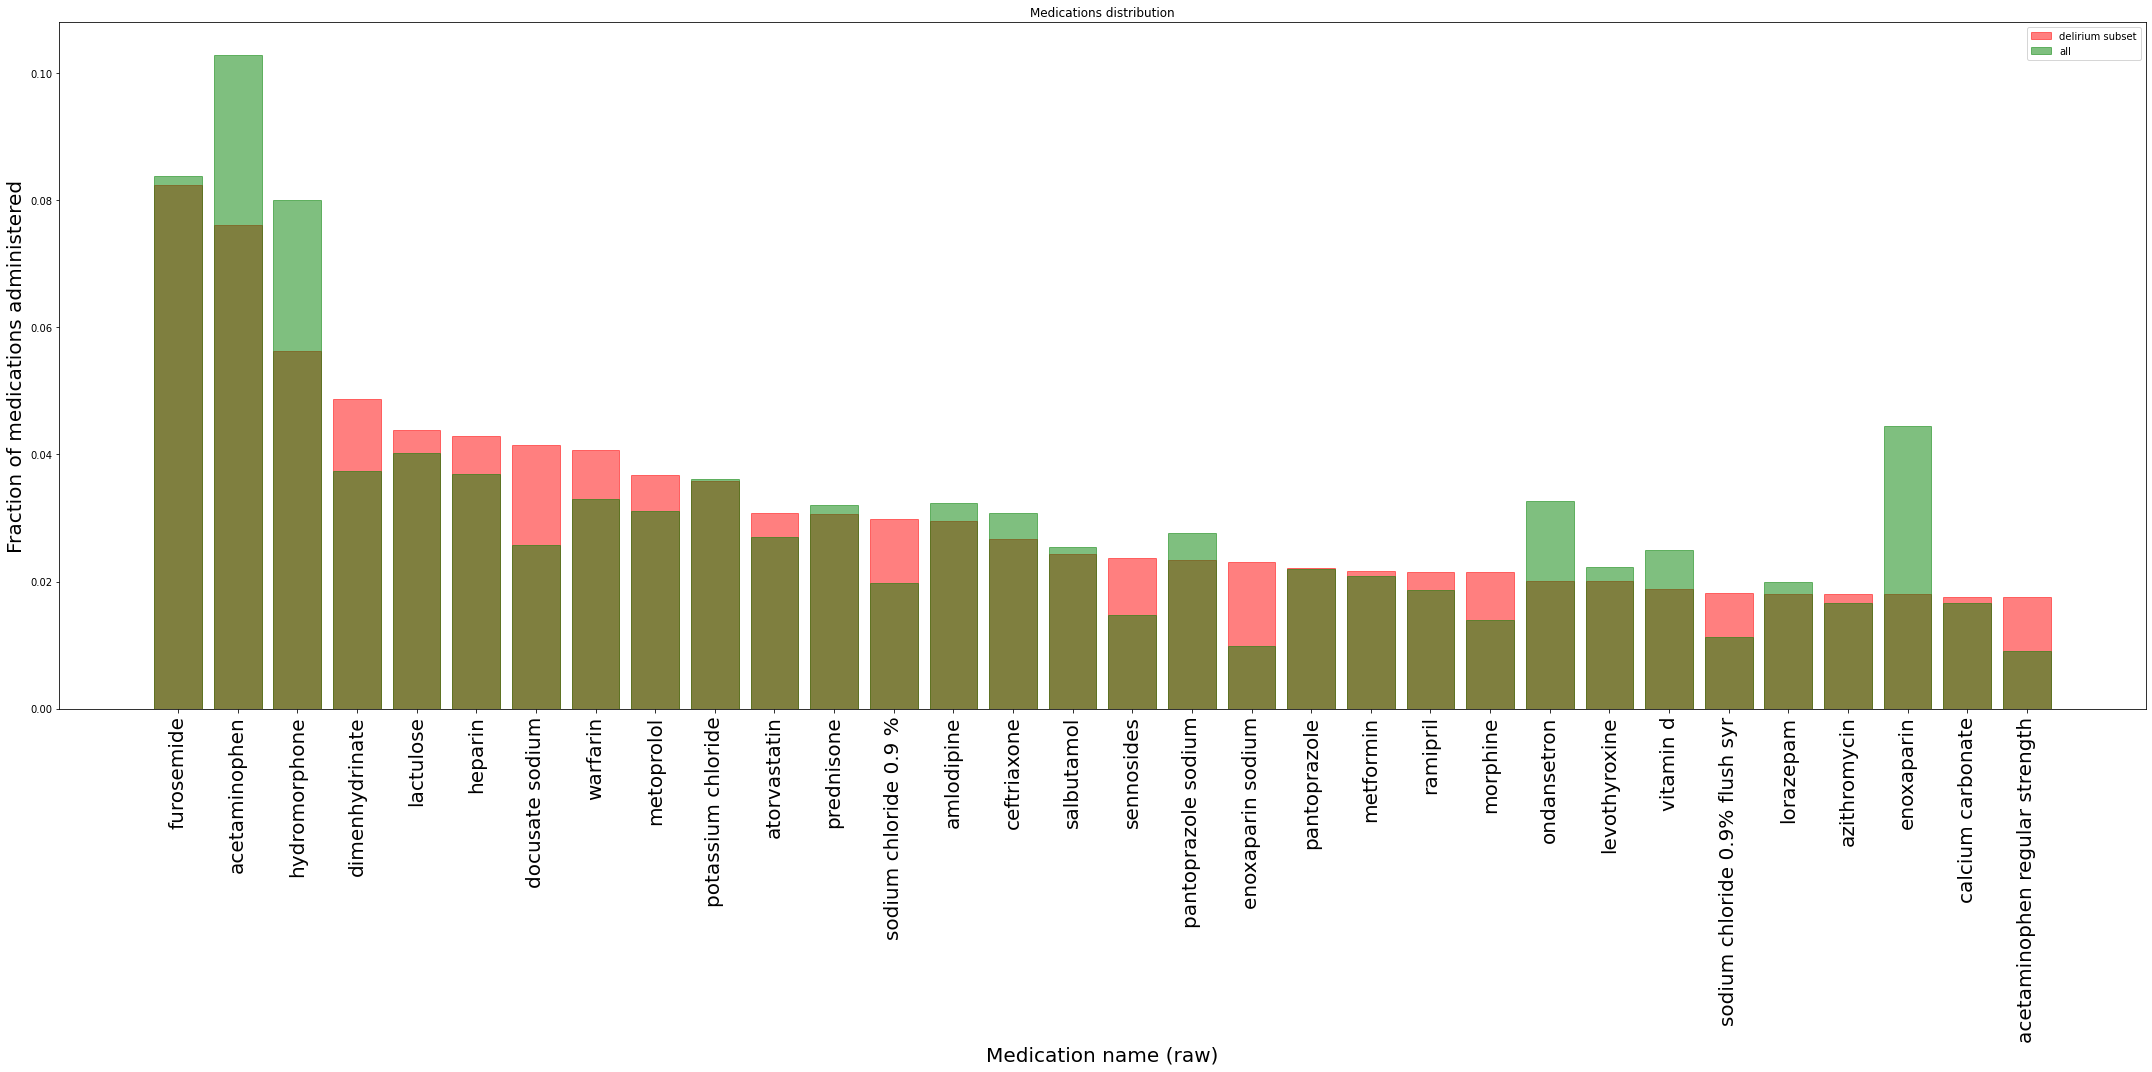

In [21]:
k = 33
medication_name = func.lower(db.public.pharmacy.med_id_generic_name_raw)
pharmacy_query = select(db.public.pharmacy.x,
                        medication_name.label(MEDICATION_NAME)).subquery()
query = select(db.public.ip_administrative.patient_id_hashed.label(PATIENT_ID),
               db.public.ip_administrative.genc_id,
               db.public.ip_administrative.hospital_id,
               db.public.ip_administrative.del_present,
               db.public.ip_administrative.gemini_cohort,
               pharmacy_query
              ).join(pharmacy_query,
                     db.public.ip_administrative.genc_id == pharmacy_query.c.genc_id
                    ).where(db.public.ip_administrative.gemini_cohort == True)
pharmacy_data = db.run_query(query)
del_meds_counts = pharmacy_data[MEDICATION_NAME].value_counts().head(k).to_dict()
del_meds_counts.pop('') # Seems to be an entry with no name.
del_meds_counts_values = np.array(list(del_meds_counts.values())) / sum(del_meds_counts.values())

fig, axs = plt.subplots(1, 1, figsize=(30, 15), tight_layout=True)
del_meds_bars = axs.bar(list(range(len(del_meds_counts))), del_meds_counts_values, alpha = 0.5)
set_bars_color(del_meds_bars, 'r')
meds_counts_mapped = [meds_counts[med_name] for med_name in del_meds_counts.keys()]
meds_counts_mapped = np.array(meds_counts_mapped) / sum(meds_counts_mapped)
all_meds_bars = plt.bar(list(range(len(meds_counts_mapped))), meds_counts_mapped, alpha = 0.5)
set_bars_color(all_meds_bars, 'g')
axs.set_xticks(range(len(del_meds_bars)), del_meds_counts.keys(), rotation='vertical', fontsize=20)
setup_plot(axs, 
           "Medications distribution",
           "Medication name (raw)", 
           "Fraction of medications administered",
           ['delirium subset', 'all'])

plt.show()